In [1]:
%matplotlib inline
from pi_filter import IIR_PI_Filter, calculate_pi_coefficients, \
                      DelayIntegratorPlantModel, sim_delay_integrator, \
                      fit_delay_integrator, simulate_controlled_plant
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import random
from pathlib import Path
import os
output_directory = Path("generated")

if not output_directory.exists():
    os.makedirs(str(output_directory))

# Simulate and plot the model

In [2]:
def plot_delay_integrator_response(t, y):
    """
    Plots a delay + integrator system response to a constant input.
    
    Parameters:
    - K: Integrator gain (slope after delay)
    - delay: Delay time (s) before integration starts
    - duration: Total simulation time (s)
    - dt: Time step (s)
    - input_value: Constant input applied at t=0
    """

    popt, _ = fit_delay_integrator(t, y)
    K, delay, y0 = popt
    y_delay = y[t>=delay][0]
    
    fig, ax = plt.subplots(figsize=(8, 4))

    ax.plot(t, y, label="Output", color='blue', lw=2)

    # Markers and annotations
    ax.axvline(x=delay, color='gray', linestyle='--', label=f"Delay = {delay}s")

    # Draw slope line
    t_slope = np.array([delay, delay + 2])
    y_slope = y_delay + (t_slope - delay) * K

    # Annotations
    ax.annotate("Delay $\\theta$", xy=(delay, y_delay), xytext=(delay - 1, y_delay + 0.5),
                arrowprops=dict(arrowstyle="->"))
    ax.annotate("Integrator\nSlope K'", xy=(t_slope[1], y_slope[1]), xytext=(delay - 1, y_slope[1]),
                arrowprops=dict(arrowstyle="->"))

    ax.set_title("Delay + Integrator Response to Step Input")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Output")
    ax.grid(True)
    plt.tight_layout()
    ax.set_ylim([0, max(ax.get_ylim())])
    return fig, ax

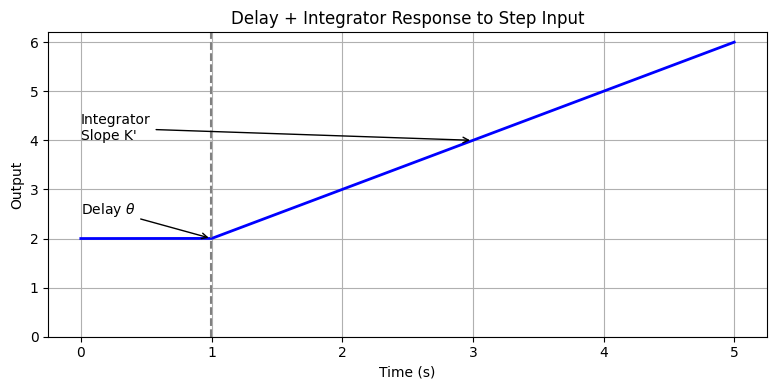

In [3]:
delay = 1
t, y = sim_delay_integrator(dt=1e-4, delay=delay, K=1)
popt, _ = fit_delay_integrator(t, y, diff_thresh=0.01)

fig, ax = plot_delay_integrator_response(t, y)
fig.savefig(output_directory / "delay-integrator-step-output.svg")
plt.show()

## Simulate the open-loop plant cooling to ambient

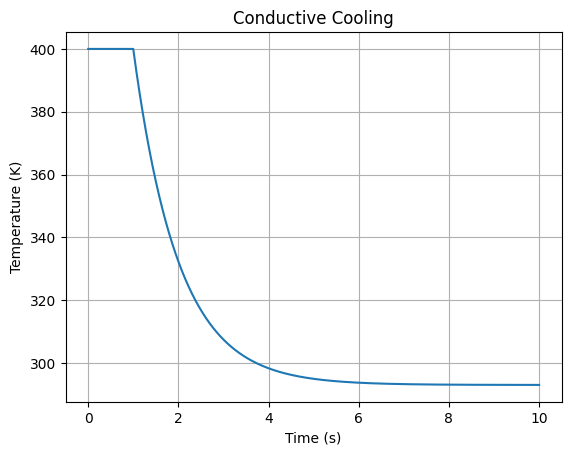

In [4]:
p = DelayIntegratorPlantModel(delay=1, gain=1, rate=1000, ambient=293, temperature=400, heat_leak=1)
data = [p.update(0) for _ in range(10 * int(p.delay * p.rate))]

time = np.linspace(0, 10, len(data))
plt.plot(time, data)
plt.title("Conductive Cooling")
plt.xlabel("Time (s)")
plt.ylabel("Temperature (K)")
plt.grid(True)
plt.savefig(output_directory / "conductive-cooling.svg")
plt.show()

## Open loop step response

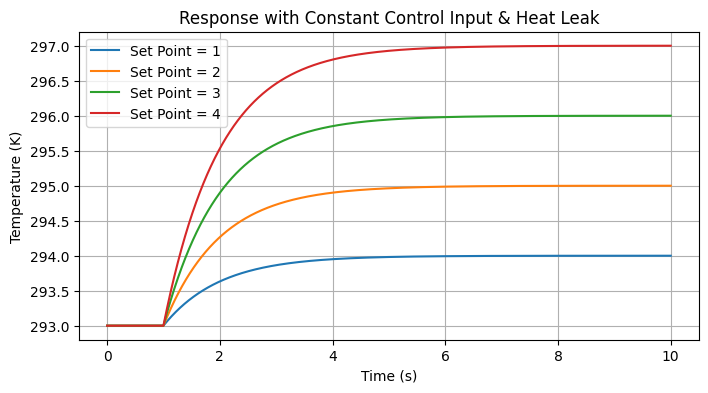

In [5]:
fig, ax = plt.subplots(figsize=(8, 4))

for set_point in range(1,5):
    d = []
    p.reset()
    p.temperature = p.ambient
    for _ in range(10*p.delay*p.rate):
        d.append(p.update(set_point))
    time = np.linspace(0, 10, len(d))
    ax.plot(time, d, label="Set Point = %d"%set_point)

ax.set_title("Response with Constant Control Input & Heat Leak")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Temperature (K)")
plt.legend()
ax.grid(True)
plt.savefig(output_directory / "ambient-heat-leak-with-constant-control.svg")
plt.show()

# Plot of stepped $\tau_c$ tuning values

In [6]:
def plot_set(plant, temp, integral, command, title=""):
    plt.plot(temp, label="Temperature")
    plt.axhline(plant.set_point, color="gray", linestyle="--", label="Set Point")
    plt.title(f"{title}: Temperature Response")
    plt.xlabel("Sample Number")
    plt.ylabel("Temperature (K)")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    plt.plot(integral, label="Integral")
    plt.title(f"{title}: Integral Term")
    plt.xlabel("Sample Number")
    plt.ylabel("Integral Value")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    
    plt.plot(command, label="Control")
    plt.title(f"{title}: Control Signal")
    plt.xlabel("Sample Number")
    plt.ylabel("Control Output")
    plt.legend()
    plt.grid(True)
    plt.show()

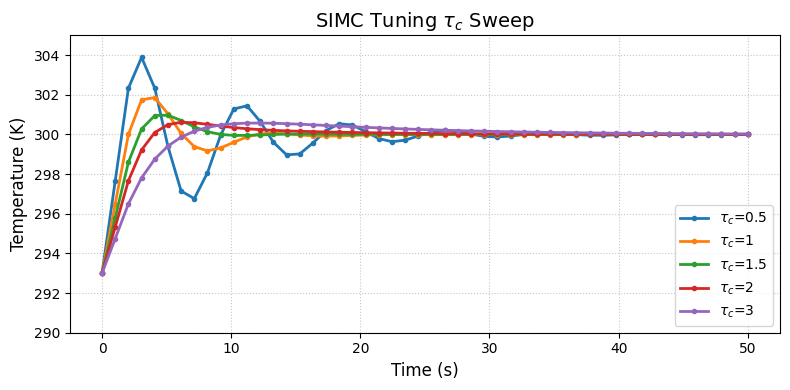

In [7]:
# Heat leak is units of A/degree -> w/ 1 Amp limit and 7 degree difference max value is 1/7 
p = DelayIntegratorPlantModel(delay=1, gain=1, ambient=293, heat_leak=0)
p.reset()
set_point = 300

fig, ax = plt.subplots(figsize=(8, 4))
for tc in (0.5,1,1.5,2,3):
    method = "simc"
    kp, ki = calculate_pi_coefficients(p.delay, p.gain, update_frequency=p.rate, method=method, tc=tc)
    ki *= p.rate
    sim_length = 50*p.delay*p.rate
    time = np.linspace(0, sim_length/p.rate, sim_length)
    filt = IIR_PI_Filter(kp=kp, ki=ki, sample_time=1/p.rate, set_point=set_point)
    results = simulate_controlled_plant(plant=p, filt=filt, npoints=sim_length)
    p.reset()
    ax.plot(time, results["temp"], ".-", label=f"$\\tau_c$={tc}", linewidth=2)

# Title and axis labels
ax.set_title(f"{method.upper()} Tuning $\\tau_c$ Sweep", fontsize=14)
ax.set_xlabel("Time (s)", fontsize=12)
ax.set_ylabel("Temperature (K)", fontsize=12)
ax.set_ylim([290, 305])
# Grid, legend, and layout
ax.grid(True, linestyle=':', alpha=0.7)
ax.legend(fontsize=10)
plt.tight_layout()
fig.savefig(output_directory / "ideal-integrator-theta-range.svg")
plt.show()

# Plots of the ideal, current limited, and current limited with anti-windup.

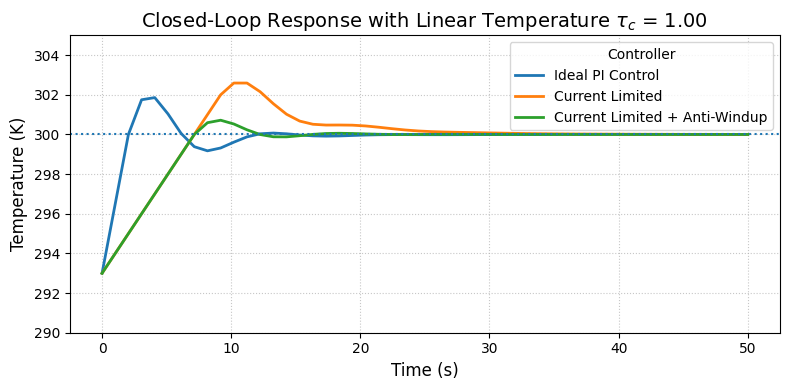

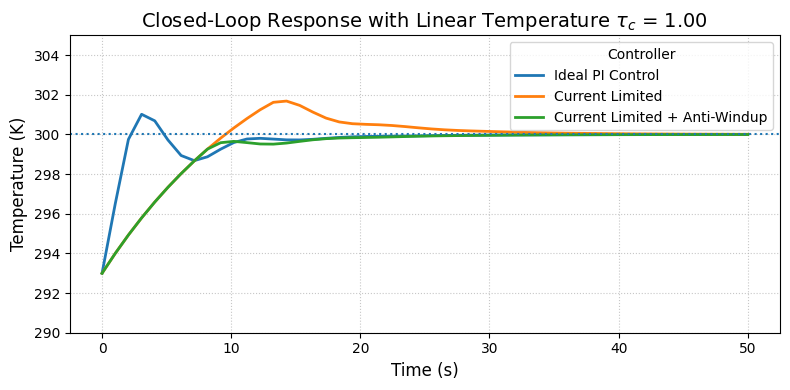

In [8]:
# Heat leak is units of A/degree -> w/ 1 Amp limit and 7 degree difference max value is 1/7 
def simulate_filters(plant, tc=1, ilim=(-1,1)):
    set_point = 300
    method = "simc"
    kp, ki = calculate_pi_coefficients(plant.delay, plant.gain, update_frequency=plant.rate, method=method, tc=tc)
    ki *= plant.rate
    sim_length = 50*plant.delay*plant.rate
    time = np.linspace(0, sim_length/plant.rate, sim_length)
    filters = pd.DataFrame([
        {"title": "Ideal PI Control", 
         "filter": IIR_PI_Filter(kp=kp, ki=ki, sample_time=1/plant.rate, set_point=set_point)},
        {"title": "Current Limited", 
         "filter": IIR_PI_Filter(kp=kp, ki=ki, sample_time=1/plant.rate, set_point=set_point, ilim=ilim)},
        {"title": "Current Limited + Anti-Windup", 
         "filter": IIR_PI_Filter(kp=kp, ki=ki, sample_time=1/plant.rate, set_point=set_point, ilim=ilim, antiwindup="conditional")},
    ])

    simulation_results = [simulate_controlled_plant(plant=p, filt=line["filter"], npoints=sim_length) for _, line in filters.iterrows()]
    sim_df = pd.DataFrame(simulation_results)
    filters[sim_df.columns] = sim_df
    return filters
    

for heatleak in [0, 1/7*0.5]:
    tc = 1
    p = DelayIntegratorPlantModel(delay=1, gain=1, ambient=293, temperature=0, heat_leak=heatleak)
    filters = simulate_filters(tc=tc, plant=p)
    fig, ax = plt.subplots(figsize=(8, 4))
    for _, line in filters.iterrows():
        ax.plot(time, line["temp"], label=line["title"], linewidth=2)
    
    # Title and axis labels
    ax.set_title(f"Closed-Loop Response with Linear Temperature $\\tau_c$ = {tc:.2f}", fontsize=14)
    ax.set_xlabel("Time (s)", fontsize=12)
    ax.set_ylabel("Temperature (K)", fontsize=12)
    ax.set_ylim([290, 305])
    # Grid, legend, and layout
    ax.grid(True, linestyle=':', alpha=0.7)
    ax.legend(title="Controller", fontsize=10)
    ax.axhline(300, linestyle=':', label="set point")
    plt.tight_layout()
    fig.savefig(output_directory / f"ideal-current-limit-windup-tauc{tc}-heatleak-{heatleak}.svg")
    plt.show()

# Add unidirectional controller, show forcing recovery

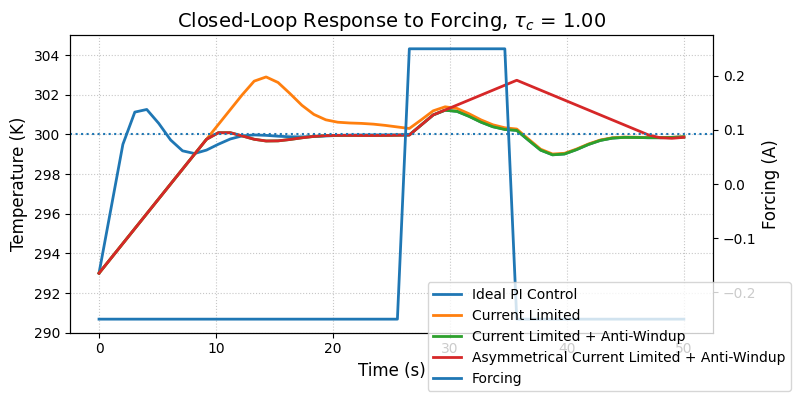

In [9]:
def simulate_filters(plant, tc=1, ilim=(-1,1)):
    set_point = 300
    method = "simc"
    kp, ki = calculate_pi_coefficients(p.delay, p.gain, update_frequency=p.rate, method=method, tc=tc)
    ki *= p.rate
    sim_length = 50*p.delay*p.rate
    time = np.linspace(0, sim_length/p.rate, sim_length)
    filters = pd.DataFrame([
        {"title": "Ideal PI Control", 
         "filter": IIR_PI_Filter(kp=kp, ki=ki, sample_time=1/p.rate, set_point=set_point)},
        {"title": "Current Limited", 
         "filter": IIR_PI_Filter(kp=kp, ki=ki, sample_time=1/p.rate, set_point=set_point, ilim=ilim)},
        {"title": "Current Limited + Anti-Windup", 
         "filter": IIR_PI_Filter(kp=kp, ki=ki, sample_time=1/p.rate, set_point=set_point, ilim=ilim, antiwindup="conditional")},
        {"title": "Asymmetrical Current Limited + Anti-Windup", 
         "filter": IIR_PI_Filter(kp=kp, ki=ki, sample_time=1/p.rate, set_point=set_point, ilim=(0,1), antiwindup="conditional")},
    ])
    
    calc_forcing = lambda x: 0.25 if (x > 25 and x < 35) else -0.25
    forcing = [calc_forcing(i) for i in range(sim_length)]

    simulation_results = [
        simulate_controlled_plant(
            plant=p, filt=line["filter"], npoints=sim_length, forcing=forcing) for _, line in filters.iterrows()]
    sim_df = pd.DataFrame(simulation_results)
    filters[sim_df.columns] = sim_df
    return filters, forcing
    

heatleak = 0
tc = 1
p = DelayIntegratorPlantModel(delay=1, gain=1, ambient=293, temperature=0, heat_leak=heatleak)
filters, forcing = simulate_filters(tc=tc, plant=p)
fig, ax = plt.subplots(figsize=(8, 4))
for _, line in filters.iterrows():
    ax.plot(time, line["temp"], label=line["title"], linewidth=2)

ax2 = ax.twinx()
ax2.plot(time, forcing, label="Forcing", linewidth=2)
ax2.set_ylabel("Forcing (A)", fontsize=12)

# Title and axis labels
ax.set_title(f"Closed-Loop Response to Forcing, $\\tau_c$ = {tc:.2f}", fontsize=14)
ax.set_xlabel("Time (s)", fontsize=12)
ax.set_ylabel("Temperature (K)", fontsize=12)
ax.set_ylim([290, 305])
# Grid, legend, and layout
ax.grid(True, linestyle=':', alpha=0.7)
fig.legend(loc="lower right")
ax.axhline(300, linestyle=':', label="set point")
plt.tight_layout()
fig.savefig(output_directory / f"ideal-current-limit-windup-tauc{tc}-asymmetrical-forcing.svg")
plt.show()

# Add noise forcing showing control around ambient and away from ambient

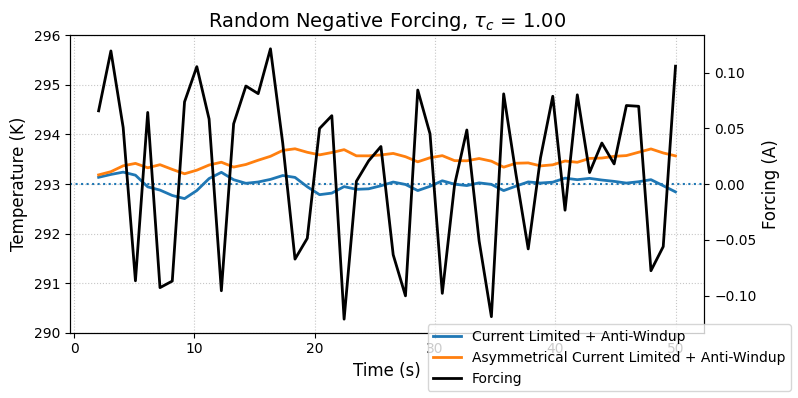

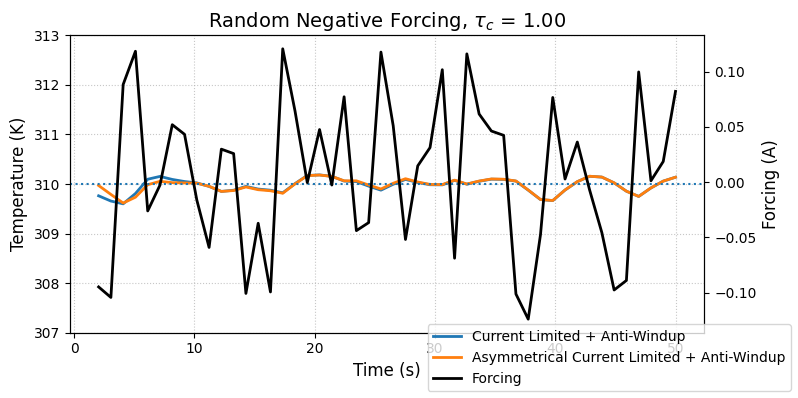

In [12]:
def simulate_filters(plant, tc=1, set_point=300, ilim=(-1,1), reset=False):
    method = "simc"
    kp, ki = calculate_pi_coefficients(p.delay, p.gain, update_frequency=p.rate, method=method, tc=tc)
    ki *= p.rate
    sim_length = 50*p.delay*p.rate
    time = np.linspace(0, sim_length/p.rate, sim_length)
    filters = pd.DataFrame([
        {"title": "Current Limited + Anti-Windup", 
         "filter": IIR_PI_Filter(kp=kp, ki=ki, sample_time=1/p.rate, set_point=set_point, ilim=ilim, antiwindup="conditional")},
        {"title": "Asymmetrical Current Limited + Anti-Windup", 
         "filter": IIR_PI_Filter(kp=kp, ki=ki, sample_time=1/p.rate, set_point=set_point, ilim=(0,1), antiwindup="conditional")},
    ])
    
    calc_forcing = lambda x: (random.random()-0.5)/4
    forcing = [calc_forcing(i) for i in range(sim_length)]

    simulation_results = [
        simulate_controlled_plant(
            plant=p, filt=line["filter"], npoints=sim_length, forcing=forcing, reset=False) for _, line in filters.iterrows()]
    sim_df = pd.DataFrame(simulation_results)
    filters[sim_df.columns] = sim_df
    return filters, forcing
    

for set_point in [293, 310]:
    ambient=293
    heatleak = 0.005
    tc = 1
    p = DelayIntegratorPlantModel(delay=1, gain=1, ambient=ambient, temperature=set_point, heat_leak=heatleak)
    
    filters, forcing = simulate_filters(tc=tc, plant=p, set_point=set_point, reset=False)
    fig, ax = plt.subplots(figsize=(8, 4))
    ax2 = ax.twinx()
    ax2.plot(time[2:], forcing[2:], 'k', label="Forcing", linewidth=2)
    ax2.set_ylabel("Forcing (A)", fontsize=12)
    
    for _, line in filters.iterrows():
        ax.plot(time[2:], line["temp"][2:], label=line["title"], linewidth=2)
    
    
    # Title and axis labels
    ax.set_title(f"Random Negative Forcing, $\\tau_c$ = {tc:.2f}", fontsize=14)
    ax.set_xlabel("Time (s)", fontsize=12)
    ax.set_ylabel("Temperature (K)", fontsize=12)
    ax.set_ylim([set_point-3, set_point+3])
    # Grid, legend, and layout
    ax.grid(True, linestyle=':', alpha=0.7)
    fig.legend(loc="lower right")
    ax.axhline(set_point, linestyle=':', label="set point")
    plt.tight_layout()
    fig.savefig(output_directory / f"ideal-current-limit-windup-tauc{tc}-asymmetrical-forcing-{set_point}.svg")
    plt.show()

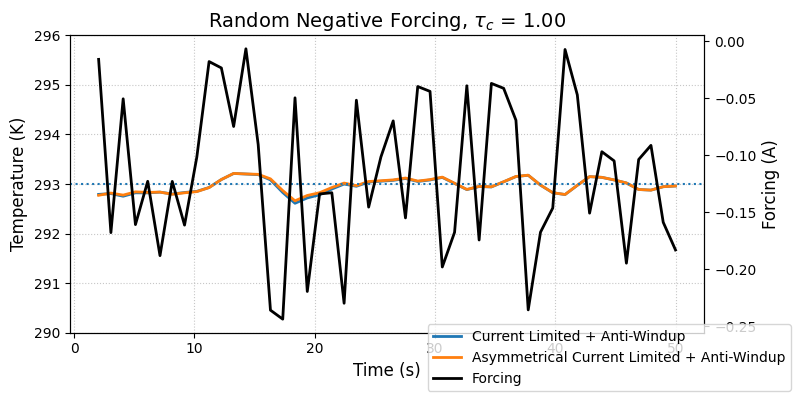

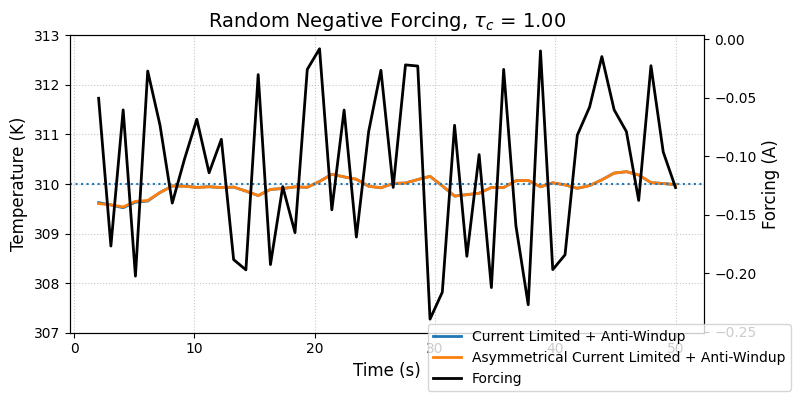

In [11]:
def simulate_filters(plant, tc=1, set_point=300, ilim=(-1,1), reset=False):
    method = "simc"
    kp, ki = calculate_pi_coefficients(p.delay, p.gain, update_frequency=p.rate, method=method, tc=tc)
    ki *= p.rate
    sim_length = 50*p.delay*p.rate
    time = np.linspace(0, sim_length/p.rate, sim_length)
    filters = pd.DataFrame([
        {"title": "Current Limited + Anti-Windup", 
         "filter": IIR_PI_Filter(kp=kp, ki=ki, sample_time=1/p.rate, set_point=set_point, ilim=ilim, antiwindup="conditional")},
        {"title": "Asymmetrical Current Limited + Anti-Windup", 
         "filter": IIR_PI_Filter(kp=kp, ki=ki, sample_time=1/p.rate, set_point=set_point, ilim=(0,1), antiwindup="conditional")},
    ])
    
    calc_forcing = lambda x: (random.random()-1)/4
    forcing = [calc_forcing(i) for i in range(sim_length)]

    simulation_results = [
        simulate_controlled_plant(
            plant=p, filt=line["filter"], npoints=sim_length, forcing=forcing, reset=False) for _, line in filters.iterrows()]
    sim_df = pd.DataFrame(simulation_results)
    filters[sim_df.columns] = sim_df
    return filters, forcing
    

for set_point in [293, 310]:
    ambient=293
    heatleak = 0.005
    tc = 1
    p = DelayIntegratorPlantModel(delay=1, gain=1, ambient=ambient, temperature=set_point, heat_leak=heatleak)
    
    filters, forcing = simulate_filters(tc=tc, plant=p, set_point=set_point, reset=False)
    fig, ax = plt.subplots(figsize=(8, 4))
    ax2 = ax.twinx()
    ax2.plot(time[2:], forcing[2:], 'k', label="Forcing", linewidth=2)
    ax2.set_ylabel("Forcing (A)", fontsize=12)
    
    for _, line in filters.iterrows():
        ax.plot(time[2:], line["temp"][2:], label=line["title"], linewidth=2)
    
    
    # Title and axis labels
    ax.set_title(f"Random Negative Forcing, $\\tau_c$ = {tc:.2f}", fontsize=14)
    ax.set_xlabel("Time (s)", fontsize=12)
    ax.set_ylabel("Temperature (K)", fontsize=12)
    ax.set_ylim([set_point-3, set_point+3])
    # Grid, legend, and layout
    ax.grid(True, linestyle=':', alpha=0.7)
    fig.legend(loc="lower right")
    ax.axhline(set_point, linestyle=':', label="set point")
    plt.tight_layout()
    fig.savefig(output_directory / f"ideal-current-limit-windup-tauc{tc}-asymmetrical-negative-forcing-{set_point}.svg")
    plt.show()